# Calculating Hamiltonian, running multiple distances

For $H_2$ that was calculated by chat GPT. Now do calculations and measure for different distances.

Ansatz from: https://pmc.ncbi.nlm.nih.gov/articles/PMC9979602/

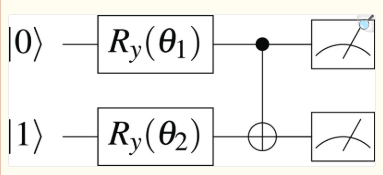

Data expecting: https://arxiv.org/pdf/2012.09265

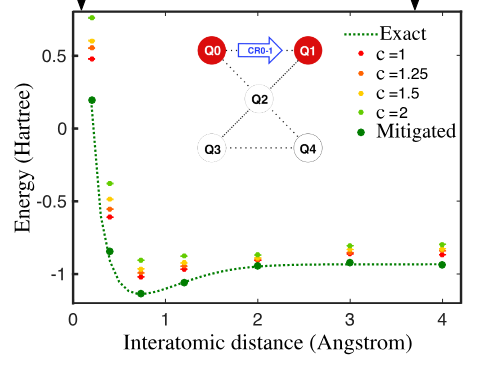

In [23]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from matplotlib import pyplot as plt
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import StatevectorEstimator

In [24]:
def make_hydrogen_hamiltonian(distance: float) -> QuantumCircuit:
    """
    Create a reduced 2-qubit Hamiltonian for a hydrogen molecule with given H-H distance.

    Args:
        distance (float): The distance between the two hydrogen atoms in angstroms.

    Returns:
        QuantumCircuit: The Hamiltonian as a quantum circuit.
    """
    driver = PySCFDriver(
        atom=f'H .0 .0 .0; H .0 .0 {distance}',
        unit=DistanceUnit.ANGSTROM,
        basis='sto3g',
    )
    problem = driver.run()

    mapper = ParityMapper(num_particles=problem.num_particles)
    return mapper.map(problem.hamiltonian.second_q_op())

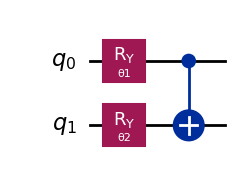

In [25]:
theta1 = Parameter('θ1')
theta2 = Parameter('θ2')

ansatz = QuantumCircuit(2)
ansatz.ry(theta1, 0)
ansatz.ry(theta2, 1)
ansatz.cx(0, 1)
ansatz.draw("mpl")

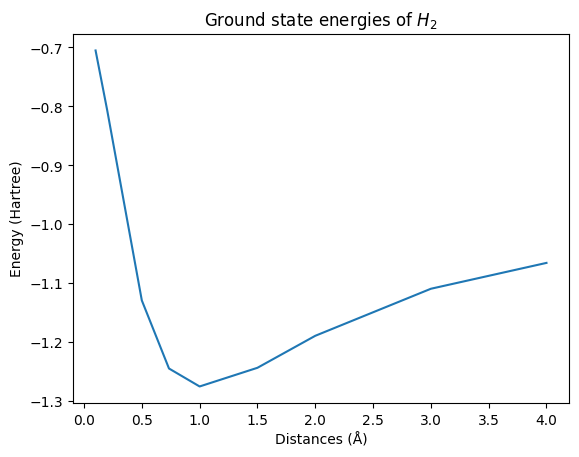

In [29]:
# SIMULATOR
optimizer = L_BFGS_B()
initial_point = np.zeros(ansatz.num_parameters)
estimator = StatevectorEstimator()
distance_shots=[0.1, 0.2, 0.5, 0.735, 1.0, 1.5, 2.0, 3.0, 4.0]
convergences = []

for i in distance_shots:
    qubit_hamiltonian = make_hydrogen_hamiltonian(i)
    def estimate_energy(parameters):
        job = estimator.run(
            [(ansatz, qubit_hamiltonian, parameters)]
        )
        result = job.result()[0].data.evs
        return result
    
    initial_point = np.zeros(ansatz.num_parameters)
    result = optimizer.minimize(fun=estimate_energy, x0=initial_point)
    convergences.append(result)

energies = [res.fun for res in convergences]
plt.plot(distance_shots, energies)
plt.xlabel('Distances (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('Ground state energies of $H_2$')
plt.show()